=== Gradientinis metodas (greičiausio nusileidimo, Armijo) ===
n (esamos) = 6, m (naujos) = 3
Parametrai: alpha0=1.0, beta=0.6, sigma=1e-4, tol=1e-6, max_iter=3000
Iteracijų sk.: 35
F: pradžia=13.116381, pabaiga=0.564566 (pagerėjimas 12.551815)

=== Esamos parduotuvės (x, y) ===
        x         y
 2.501909  7.944276
 5.513714 -5.495856
-3.996674  7.471069
-9.894694  6.424568
 5.941389 -0.641301
-3.939351 -4.431488

=== Pradinės naujų (x, y) ===
        x         y
-4.902608 -1.098474
 0.090965  1.069947
 9.910006  5.853238

=== Optimizuotos naujų (x, y) ===
        x         y
-1.218459 -2.563789
-1.513804  2.725477
 3.542611  2.763331


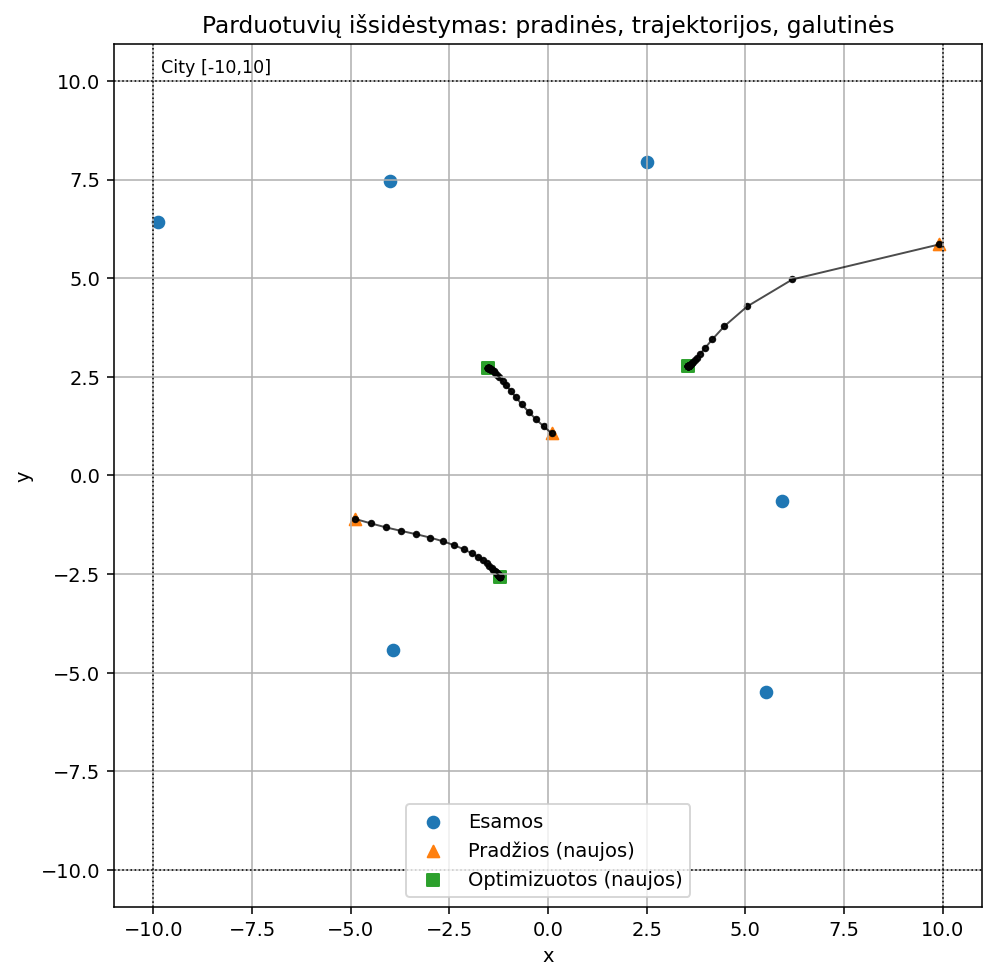

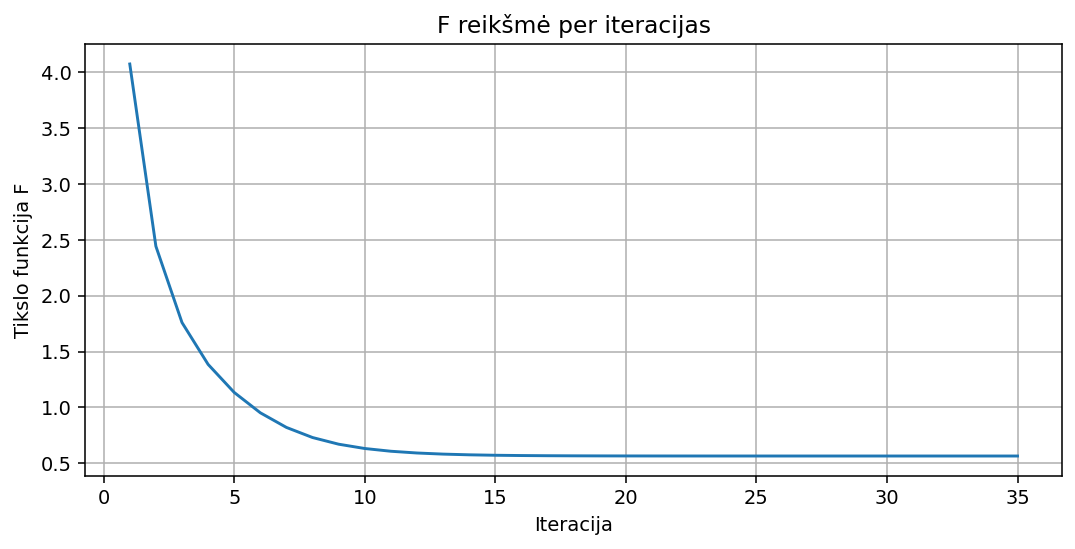

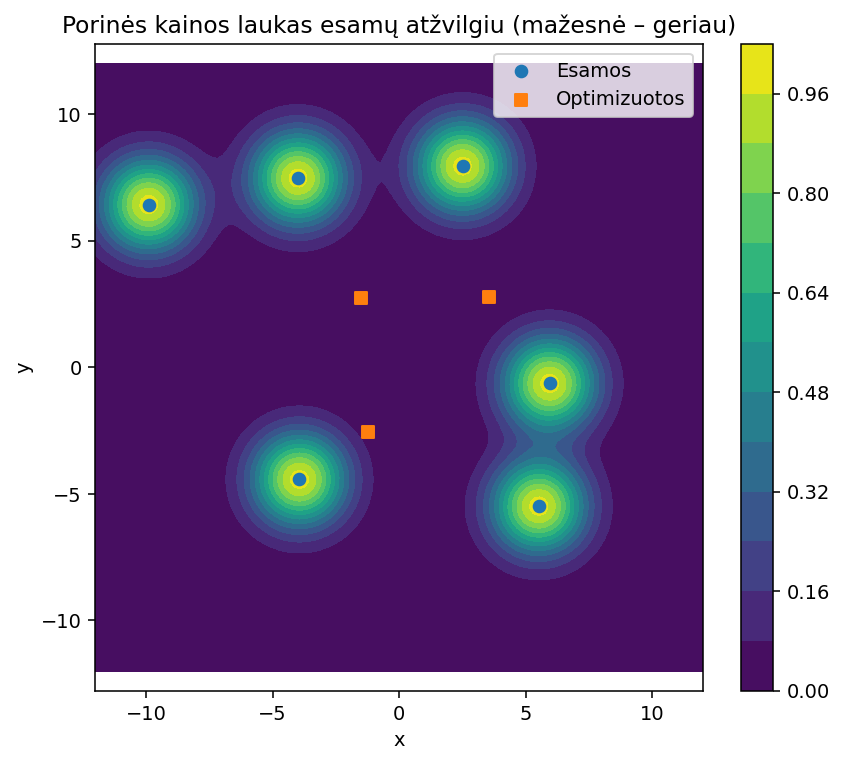

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

rng = np.random.default_rng(7)

n = 6   #esamų parduotuvių skaičius (n>=3)
m = 3   #naujų parduotuvių skaičius (m>=3)

#Esamų parduotuvių koordinatės intervale [-10,10]
existing_xy = rng.uniform(-10.0, 10.0, size=(n, 2))

#Pradinės naujų parduotuvių vietos
x0_new = rng.uniform(-10.0, 10.0, size=(m, 2))

#Porinė kaina tarp dviejų parduotuvių p=(x,y), q=(x,y): exp(-0.3*||p-q||^2)
def C_pair(p, q):
    d2 = np.sum((p - q) ** 2)
    return np.exp(-0.3 * d2)

#Vietos (statybos) kaina vienai parduotuvei p=(x,y)
def Cp(p):
    x, y = p
    return (x**4 + y**4) / 1000.0 + (np.sin(x) + np.cos(y)) / 5.0 + 0.4

#Bendra tikslo funkcija F
#Įėjimas: 'flat_new' – vektorius [x1,y1,...,xm,ym], 'existing' – esamų parduotuvių masyvas
#Išėjimas: skaliarinė F reikšmė
def objective(flat_new, existing):
    P = flat_new.reshape(-1, 2)

    #Vietos kainų suma
    F = np.sum([Cp(p) for p in P])

    #Porinės kainos tarp naujų ir esamų
    for p in P:
        F += np.sum([C_pair(p, q) for q in existing])

    #Porinės kainos tarp pačių naujų (kiekvieną porą skaičiuojame 1 kartą: j<k)
    for j in range(len(P)):
        for k in range(j + 1, len(P)):
            F += C_pair(P[j], P[k])

    return float(F)

#Analitinis F gradientas pagal naujų parduotuvių koordinates
#Grąžina tokios pačios formos vektorių kaip 'flat_new'
def gradient(flat_new, existing):
    P = flat_new.reshape(-1, 2)
    grad = np.zeros_like(P)

    #Vietos kainos Cp išvestinės
    grad[:, 0] += 4.0 * P[:, 0] ** 3 / 1000.0 + np.cos(P[:, 0]) / 5.0
    grad[:, 1] += 4.0 * P[:, 1] ** 3 / 1000.0 - np.sin(P[:, 1]) / 5.0

    #Porinės kainos su esamomis parduotuvėmis
    for j, p in enumerate(P):
        diffs = p - existing
        d2 = np.sum(diffs**2, axis=1)
        e = np.exp(-0.3 * d2)
        grad[j] += np.sum(((-0.6) * e)[:, None] * diffs, axis=0)

    #Porinės kainos tarp pačių naujų: kiekvieną neordinuotą porą skaičiuojame kartą (j<k)
    m_pts = len(P)
    for j in range(m_pts):
        for k in range(j + 1, m_pts):
            diff = P[j] - P[k]
            d2 = np.dot(diff, diff)
            e = np.exp(-0.3 * d2)
            gpair = (-0.6) * e * diff      # d/d p_j
            grad[j] += gpair
            grad[k] -= gpair               # d/d p_k = -gpair
            diff = P[j] - P[k]
            d2 = np.dot(diff, diff)
            e = np.exp(-0.3 * d2)
            if j < k:
                grad[j] += (-0.6) * e * diff

    return grad.reshape(-1)

#Greičiausio nusileidimo metodas (Armijo žingsnis)
#'existing' – esamų parduotuvių masyvas
#x0 – pradinės naujų parduotuvių koordinatės (m,2)
#Grąžina: optimizuotą vektorių,
#sąrašą su f, žingsniu ir ||grad||,
#trajektoriją kiekvienai naujai parduotuvei (taškai per iteracijas)
def steepest_descent(existing, x0, max_iter=2000, tol=1e-6,
                     alpha0=1.0, beta=0.5, sigma=1e-4, track_every=1):
    x = x0.reshape(-1).astype(float)
    m = x.size // 2

    #Trajektorijos kaupimas: kiekvienai naujai parduotuvei saugom visi priimti taškai
    paths = [[x[2*j:2*j+2].copy()] for j in range(m)]
    hist = []

    f = objective(x, existing)
    for it in range(1, max_iter + 1):
        g = gradient(x, existing)
        gnorm2 = np.dot(g, g)

        #Sustabdymas pagal mažą gradiento normą
        if np.sqrt(gnorm2) < tol:
            hist.append({"iter": it, "f": f, "alpha": 0.0, "gnorm": np.sqrt(gnorm2), "stop": "||grad||<tol"})
            break

        #Armijo backtracking: ieškomas žingsnis alpha, tenkinantis F(x-alpha*g) <= F(x) - sigma*alpha*||g||^2
        alpha = alpha0
        dirdec = sigma * alpha * gnorm2
        while True:
            x_new = x - alpha * g
            f_new = objective(x_new, existing)
            if f_new <= f - sigma * alpha * gnorm2:   # <-- čia svarbu α kiekvieną kartą
                break
            alpha *= beta
            #žingsnis tapo per mažas – laikome, kad progresas neįmanomas
            if alpha < 1e-12:
                hist.append({"iter": it, "f": f, "alpha": alpha, "gnorm": np.sqrt(gnorm2), "stop": "alpha too small"})
                return x, hist, paths

        #Patvirtiname žingsnį
        x = x_new
        f = f_new

        #Užfiksuojame trajektorijų taškus ir istoriją
        if it % track_every == 0:
            for j in range(m):
                paths[j].append(x[2*j:2*j+2].copy())
            hist.append({"iter": it, "f": f, "alpha": alpha, "gnorm": np.sqrt(gnorm2)})

        #Papildomas sustabdymas: labai maža santykinė pažanga
        if len(hist) >= 2:
            prevf = hist[-2]["f"]
            if abs(prevf - f) <= max(1.0, abs(prevf)) * 1e-10:
                hist.append({"iter": it, "f": f, "alpha": alpha, "gnorm": np.sqrt(gnorm2), "stop": "rel. change tiny"})
                break

    else:
        #pasiekta max_iter
        hist.append({"iter": max_iter, "f": f, "alpha": 0.0,
                     "gnorm": float(np.linalg.norm(gradient(x, existing))), "stop": "max_iter"})

    return x, hist, paths

x0 = x0_new.copy()
x_opt, history, paths = steepest_descent(
    existing=existing_xy,
    x0=x0,
    max_iter=3000,
    tol=1e-6,
    alpha0=1.0,
    beta=0.6,
    sigma=1e-4,
    track_every=1
)

P0 = x0.reshape(-1, 2)
Popt = x_opt.reshape(-1, 2)

#Santrauka ir lentelės
iters = history[-1]["iter"]
stop_reason = history[-1].get("stop", "finished")
F0 = objective(P0.reshape(-1), existing_xy)
Fopt = objective(x_opt, existing_xy)

print("=== Gradientinis metodas (greičiausio nusileidimo, Armijo) ===")
print(f"n (esamos) = {n}, m (naujos) = {m}")
print("Parametrai: alpha0=1.0, beta=0.6, sigma=1e-4, tol=1e-6, max_iter=3000")
print(f"Iteracijų sk.: {iters}")
print(f"F: pradžia={F0:.6f}, pabaiga={Fopt:.6f} (pagerėjimas {F0-Fopt:.6f})")

df_existing = pd.DataFrame(existing_xy, columns=["x", "y"])
df_start = pd.DataFrame(P0, columns=["x", "y"])
df_final = pd.DataFrame(Popt, columns=["x", "y"])

print("\n=== Esamos parduotuvės (x, y) ===")
print(df_existing.to_string(index=False))
print("\n=== Pradinės naujų (x, y) ===")
print(df_start.to_string(index=False))
print("\n=== Optimizuotos naujų (x, y) ===")
print(df_final.to_string(index=False))

#Žemėlapis su trajektorijomis
plt.figure(figsize=(8, 8), dpi=140)
#Miesto kvadratas (paryškinimui – taškai gali būti ir už ribų)
plt.axhline(-10, color='black', linestyle=':', linewidth=0.8)
plt.axhline(10,  color='black', linestyle=':', linewidth=0.8)
plt.axvline(-10, color='black', linestyle=':', linewidth=0.8)
plt.axvline(10,  color='black', linestyle=':', linewidth=0.8)
plt.text(-9.8, 10.2, "City [-10,10]", fontsize=9)

#Esamos parduotuvės
plt.scatter(existing_xy[:, 0], existing_xy[:, 1], marker='o', label='Esamos')

#Pradinės ir galutinės naujos
plt.scatter(P0[:, 0],   P0[:, 1],   marker='^', label='Pradžios (naujos)')
plt.scatter(Popt[:, 0], Popt[:, 1], marker='s', label='Optimizuotos (naujos)')

step_mark_every = 1
for path in paths:
    path = np.array(path)
    plt.plot(path[:, 0], path[:, 1], color='black', linewidth=1.0, alpha=0.7)
    plt.scatter(path[::step_mark_every, 0],
                path[::step_mark_every, 1],
                s=8, marker='o', color='black', alpha=0.9)

plt.xlabel("x"); plt.ylabel("y")
plt.title("Parduotuvių išsidėstymas: pradinės, trajektorijos, galutinės")
plt.legend(loc='best')
plt.grid(True)
plt.axis('equal')
plt.show()

#F priklausomybė nuo iteracijų
its = [h["iter"] for h in history]
vals = [h["f"] for h in history]
plt.figure(figsize=(9, 4), dpi=140)
plt.plot(its, vals, linewidth=1.5)
plt.xlabel("Iteracija")
plt.ylabel("Tikslo funkcija F")
plt.title("F reikšmė per iteracijas")
plt.grid(True)
plt.show()

#Porinės kainos lauko žemėlapis esamų atžvilgiu
xmin, xmax, ymin, ymax = -12, 12, -12, 12
gx = np.linspace(xmin, xmax, 120)
gy = np.linspace(ymin, ymax, 120)
GX, GY = np.meshgrid(gx, gy)
heat = np.zeros_like(GX)

E = existing_xy
for i in range(GX.shape[0]):
    for j in range(GX.shape[1]):
        p = np.array([GX[i, j], GY[i, j]])
        heat[i, j] = np.sum(np.exp(-0.3 * np.sum((E - p) ** 2, axis=1)))

plt.figure(figsize=(7, 6), dpi=140)
cs = plt.contourf(GX, GY, heat, levels=15)
plt.colorbar(cs)
plt.scatter(existing_xy[:, 0], existing_xy[:, 1], marker='o', label='Esamos')
plt.scatter(Popt[:, 0], Popt[:, 1], marker='s', label='Optimizuotos')
plt.title("Porinės kainos laukas esamų atžvilgiu (mažesnė – geriau)")
plt.xlabel("x"); plt.ylabel("y")
plt.legend(loc='best')
plt.axis('equal')
plt.show()
